In [2]:
from IPython.display import clear_output
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
from skimage import exposure
from matplotlib.patches import Polygon
from RSData import *
from HaiYangData import *
from tensorflow_examples.models.pix2pix import pix2pix

import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import glob
import cv2
import io
import shapefile
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# 读取数据

In [263]:
train_dir = r'E:\python_workfile\sea_ice_classification\training1'

sigmod0_img_dir = train_dir + r'\\data\\'
aari_img_dir = train_dir + r'\\mask\\'
osi_img_dir = train_dir + r'\\mask\\osisaf\\img\\'

sigmod0_npy_dir = train_dir + r'\\sigmod0\\npy\\'
aari_npy_dir = train_dir + r'\\mask\\aari\\npy\\'
osisaf_npy_dir = train_dir + r'\\mask\\osisaf\\npy\\'

In [264]:
sigmod0_npy_files = glob.glob(sigmod0_npy_dir + '*.npy')
aari_npy_files = glob.glob(aari_npy_dir + r'*.npy')
osisaf_npy_files = glob.glob(osisaf_npy_dir + r'*.npy')

osi_array = np.load(osisaf_npy_files[0])
aari_array = np.load(aari_npy_files[0])

new_osi_array = np.full(shape=osi_array.shape[:2], fill_value=0)
new_aari_array = np.full(shape=osi_array.shape[:2], fill_value=0)


look = np.full(shape=osi_array.shape[:2], fill_value=0)

for i in range(3):
    new_osi_array += osi_array[:,:,i]
    
for i in range(3):
    new_aari_array += aari_array[:,:,i]
    

In [255]:
new_osi_array = np.full(shape=osi_array.shape[:2], fill_value=0)
new_aari_array = np.full(shape=osi_array.shape[:2], fill_value=0)


look = np.full(shape=osi_array.shape[:2], fill_value=0)

In [256]:
for i in range(3):
    new_osi_array += osi_array[:,:,i]
    
for i in range(3):
    new_aari_array += aari_array[:,:,i]
    

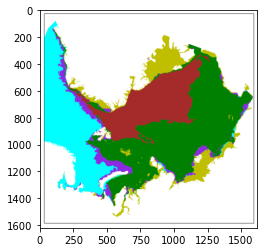

In [268]:
plt.imshow(np.load(aari_npy_files[0]))

In [274]:
aari_dict = {765:1, 128:2,510:3, 249:4, 382:5, 407:6}

In [296]:
keys = np.array(aari_dict.keys())

In [306]:
vals

array([1, 2, 3, 4, 5, 6])

In [305]:
vals = np.array([aari_dict[key] for key in aari_dict.keys()])



In [256]:
result = vals[inv]

In [288]:
map(lambda x:aari_dict[x], new_aari_array)

In [292]:
new_aari_array[0][0]

1

In [309]:
sigmod0_npy_files[0].split('\\')[-1]

'HY2B_sca_sigmod0_20200401.npy'

In [312]:

for aari_npy_file, sigmod0_npy_file in zip(aari_npy_files, sigmod0_npy_files):
    aari_array = np.load(aari_npy_file)
    sigmod0_array = np.load(sigmod0_npy_file)
    new_aari_array = np.full(shape=aari_array.shape[:2], fill_value=0)
    for i in range(3):
        new_aari_array += aari_array[:,:,i]
    new_aari_array[new_aari_array == 765] = 1
    new_aari_array[new_aari_array == 128] = 2
    new_aari_array[new_aari_array == 510] = 3
    new_aari_array[new_aari_array == 249] = 4
    new_aari_array[new_aari_array == 382] = 5
    new_aari_array[new_aari_array == 407] = 6
    
    np.save(aari_npy_dir + r'\\normail_npy\\' + sigmod0_npy_file.split('\\')[-1],new_aari_array)
    
        

large_num_index = np.argsort(plt.hist(new_aari_array.flatten(),bins=765)[0])[-10:]
plt.hist(new_aari_array.flatten(),bins=765)[1][large_num_index]

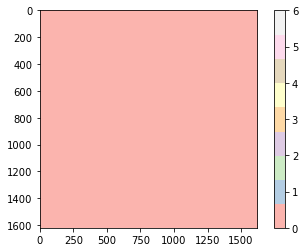

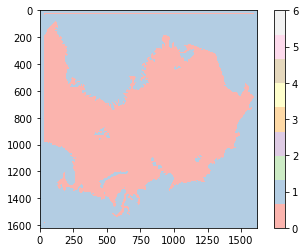

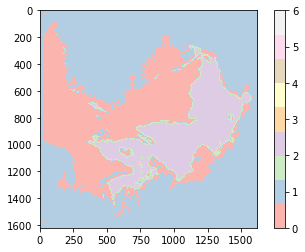

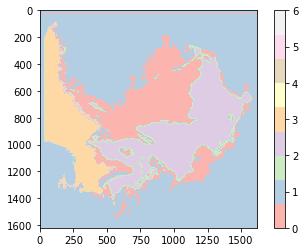

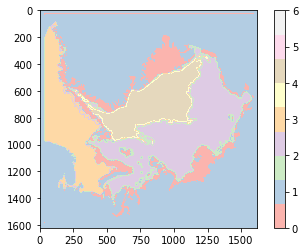

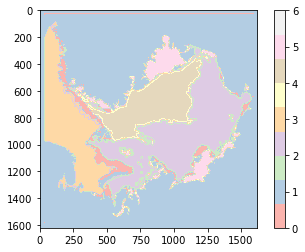

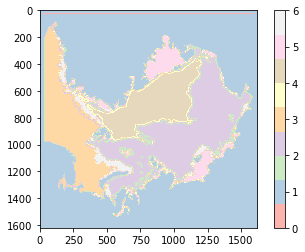

In [257]:
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_aari_array == 765] = 1 
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_aari_array == 128] = 2 
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_aari_array == 510] = 3 
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_aari_array == 249] = 4 
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_aari_array == 382] = 5
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_aari_array == 407] = 6
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()


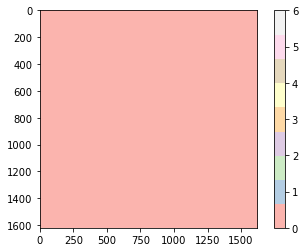

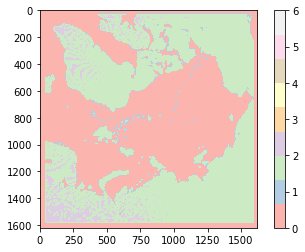

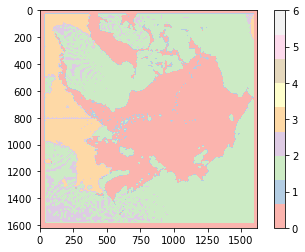

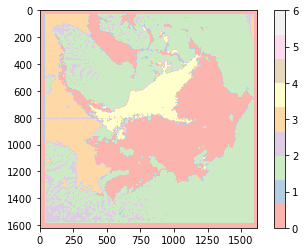

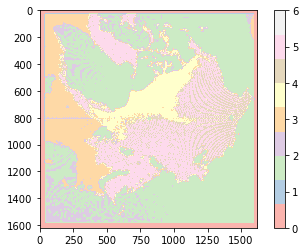

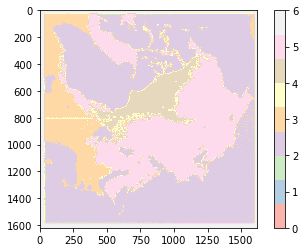

In [218]:
look[new_osi_array == 0] = 1 
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_osi_array == 128] = 2 
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_osi_array == 384] = 3 
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_osi_array == 403] = 4 
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_osi_array == 502] = 5
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()

look[new_osi_array == 765] = 6
plt.imshow(look,cmap = plt.cm.Pastel1,vmin=0,vmax = 6)
plt.colorbar()
plt.show()


In [5]:
import random
import glob
image_paths = list(glob.glob(image_dir + '*.png'))
mask_paths = list(glob.glob(mask_dir + '*.png'))
training_path = [[image,mask]for image,mask in zip(image_paths,mask_paths)]
random.shuffle(training_path)
image_count = len(training_path)
# image_count

In [6]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [7]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (1620, 1620))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (1620, 1620))
    
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [8]:
TRAIN_LENGTH = image_count
BATCH_SIZE = 2
BUFFER_SIZE = 2
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(load_and_preprocess_image(display_list[i]))
        plt.axis('off')
    plt.show()

In [10]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [1620, 1620])
  image /= 255.0  # normalize to [0,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

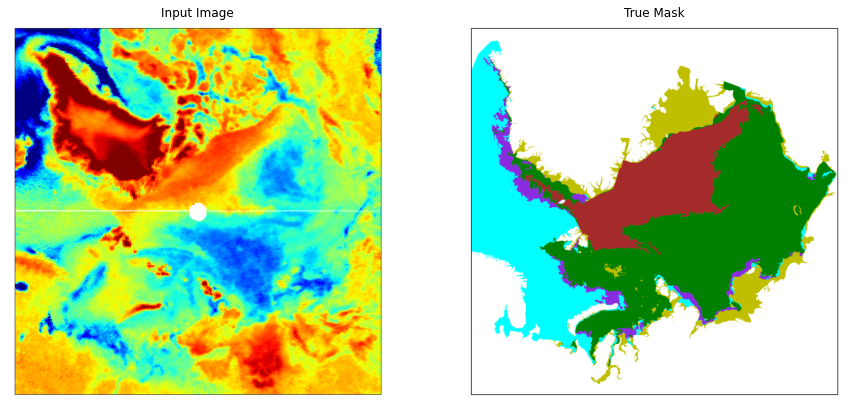

In [11]:
sample_image, sample_mask = training_path[0]
display([sample_image, sample_mask])

In [12]:
OUTPUT_CHANNELS = 3

In [13]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[1620, 1620, 3], include_top=False)

# 使用这些层的激活设置
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 创建特征提取模型
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [67]:
sigmod0_npy_dir = glob.glob(r'E:\python_workfile\sea_ice_classification\training\sigmod0\npy\*.npy')
aari_npy_dir = glob.glob(r'E:\python_workfile\sea_ice_classification\training\mask\npy\*.npy')
osisaf_npy_dir = glob.glob(r'E:\python_workfile\sea_ice_classification\training\mask\osisaf\npy\*.npy')